In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
from loguru import logger

import json
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from train_model import *

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/processed/heart_processed.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [3]:
ss = StandardScaler()
df['Oldpeak'] = ss.fit_transform(df[['Oldpeak']])
df['RestingBP'] = ss.fit_transform(df[['RestingBP']])
df['Age'] = ss.fit_transform(df[['Age']])
df['Cholesterol'] = ss.fit_transform(df[['Cholesterol']])
df['MaxHR'] = ss.fit_transform(df[['MaxHR']])

In [4]:
x = df.drop(['HeartDisease'], axis=1)
y = df['HeartDisease']

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## GridSearchCV
<p>GridSearchCV is a technique for finding the best combination of hyperparameters for a machine learning model. It tests all possible combinations of hyperparameters, evaluating each one using cross-validation. The model with the best average performance is selected as the final result. GridSearchCV helps optimize the model's performance, but it can be computationally intensive.<p>
<p>This code automates the training and evaluation of multiple classification models using different parameters for each model. Through the loop and the models_list, the results are stored for each model, allowing for the comparison of model performances and the selection of the one that achieved the best performance for the specific classification task at hand. This facilitates the process of experimenting with various models and hyperparameters, making the development of a machine learning model more efficient and scalable.<p>

In [6]:
models_list = list()

models = [
    {'name': 'SVM', 'model': SVC(), 'param_grid': {'C': [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3],
                                                   'gamma': [0.7, 0.8, 0.9, 1, 1.1, 1.2],
                                                   'kernel': ['linear', 'rbf']}},

    {'name': 'Random Forest', 'model': RandomForestClassifier(), 'param_grid': {'n_estimators': [10, 50, 100, 500, 1000],
                                                                                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                                                'criterion': ['gini', 'entropy', 'log_loss']}},

    {'name': 'K-Nearest Neighbors', 'model': KNeighborsClassifier(), 'param_grid': {'n_neighbors': [3, 5, 7],
                                                                                    'p': [1, 2],'weights': ['uniform', 'distance'],
                                                                                    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                                                                    'leaf_size': [10, 20, 30],
                                                                                    'metric': ['euclidean', 'manhattan', 'chebyshev'],
                                                                                    'n_jobs': [-1]}},

    {'name': 'Decision Tree', 'model': DecisionTreeClassifier(), 'param_grid': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                                                'min_samples_split': [2, 5, 10]}},

    {'name': 'AdaBoost', 'model': AdaBoostClassifier(), 'param_grid': {'n_estimators': [50, 100, 200, 500],
                                                                       'learning_rate': [0.1, 0.5, 1.0],
                                                                       'algorithm': ['SAMME', 'SAMME.R']}},

    {'name': 'Gradient Boosting', 'model': GradientBoostingClassifier(), 'param_grid': {'n_estimators': [50, 100, 200, 500],
                                                                                         'learning_rate': [0.1, 0.5, 1.0],
                                                                                         'max_depth': [3, 4, 5],
                                                                                         'subsample': [0.8, 1.0]}},

    {'name': 'Logistic Regression', 'model': LogisticRegression(), 'param_grid': {'C': [0.1, 0.5, 1.0, 1.5, 2.0],
                                                                                   'solver': ['liblinear', 'saga'],
                                                                                   'penalty': ['l1', 'l2', 'elasticnet'],
                                                                                   'l1_ratio': [0.1, 0.5, 0.9]}},

    {'name': 'XGBoost', 'model': XGBClassifier(), 'param_grid': {'max_depth': [3, 4, 5, 6, 7],
                                                                 'learning_rate': [0.1, 0.01, 0.001],
                                                                 'n_estimators': [50, 100, 200, 500],
                                                                 'subsample': [0.8, 1.0],
                                                                 'colsample_bytree': [0.6, 0.8, 1.0]}},

    {'name': 'Naive Bayes', 'model': GaussianNB(), 'param_grid': {}}
]

for model_info in models:
    model_name = model_info.get("name")
    model = model_info.get("model")
    param_grid = model_info.get("param_grid")

    logger.info(f"Training Model {model_name}")

    time_to_train, clf, best_params = train_model(model=model, param_grid=param_grid, x_train=x_train, y_train=y_train)
    predicted_labels = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predicted_labels)
    logger.info(f"Time to train model {time_to_train}")
    logger.info(f"Model accuracy {model_name}: {accuracy}")
    logger.info(f"Best Model Params {json.dumps(best_params, indent=4)}")

    result_model_info = {
        "model_name": model_name,
        "model_instance": clf,
        "model_accuracy": accuracy,
        "train_time": time_to_train,
    }

    models_list.append(result_model_info)

2025-01-16 21:44:37.128 | INFO     | __main__:<module>:50 - Training Model SVM


2025-01-16 21:44:40.592 | INFO     | __main__:<module>:55 - Time to train model 0:00:03.462123
2025-01-16 21:44:40.597 | INFO     | __main__:<module>:56 - Model accuracy SVM: 0.8623188405797102
2025-01-16 21:44:40.597 | INFO     | __main__:<module>:57 - Best Model Params {
    "C": 0.9,
    "gamma": 0.7,
    "kernel": "linear"
}
2025-01-16 21:44:40.597 | INFO     | __main__:<module>:50 - Training Model Random Forest


2025-01-16 21:45:21.862 | INFO     | __main__:<module>:55 - Time to train model 0:00:41.231760
2025-01-16 21:45:21.862 | INFO     | __main__:<module>:56 - Model accuracy Random Forest: 0.8695652173913043
2025-01-16 21:45:21.862 | INFO     | __main__:<module>:57 - Best Model Params {
    "criterion": "entropy",
    "max_depth": 6,
    "n_estimators": 1000
}
2025-01-16 21:45:21.862 | INFO     | __main__:<module>:50 - Training Model K-Nearest Neighbors


2025-01-16 21:45:26.573 | INFO     | __main__:<module>:55 - Time to train model 0:00:04.689674
2025-01-16 21:45:26.574 | INFO     | __main__:<module>:56 - Model accuracy K-Nearest Neighbors: 0.8586956521739131
2025-01-16 21:45:26.574 | INFO     | __main__:<module>:57 - Best Model Params {
    "algorithm": "auto",
    "leaf_size": 10,
    "metric": "manhattan",
    "n_jobs": -1,
    "n_neighbors": 5,
    "p": 1,
    "weights": "distance"
}
2025-01-16 21:45:26.574 | INFO     | __main__:<module>:50 - Training Model Decision Tree
2025-01-16 21:45:26.713 | INFO     | __main__:<module>:55 - Time to train model 0:00:00.135606
2025-01-16 21:45:26.713 | INFO     | __main__:<module>:56 - Model accuracy Decision Tree: 0.8333333333333334
2025-01-16 21:45:26.714 | INFO     | __main__:<module>:57 - Best Model Params {
    "max_depth": 3,
    "min_samples_split": 2
}
2025-01-16 21:45:26.714 | INFO     | __main__:<module>:50 - Training Model AdaBoost


2025-01-16 21:45:32.618 | INFO     | __main__:<module>:55 - Time to train model 0:00:05.888671
2025-01-16 21:45:32.618 | INFO     | __main__:<module>:56 - Model accuracy AdaBoost: 0.8478260869565217
2025-01-16 21:45:32.619 | INFO     | __main__:<module>:57 - Best Model Params {
    "algorithm": "SAMME",
    "learning_rate": 0.1,
    "n_estimators": 200
}
2025-01-16 21:45:32.620 | INFO     | __main__:<module>:50 - Training Model Gradient Boosting


2025-01-16 21:45:46.871 | INFO     | __main__:<module>:55 - Time to train model 0:00:14.249294
2025-01-16 21:45:46.872 | INFO     | __main__:<module>:56 - Model accuracy Gradient Boosting: 0.8586956521739131
2025-01-16 21:45:46.872 | INFO     | __main__:<module>:57 - Best Model Params {
    "learning_rate": 0.1,
    "max_depth": 3,
    "n_estimators": 50,
    "subsample": 0.8
}
2025-01-16 21:45:46.873 | INFO     | __main__:<module>:50 - Training Model Logistic Regression


2025-01-16 21:45:47.287 | INFO     | __main__:<module>:55 - Time to train model 0:00:00.411897
2025-01-16 21:45:47.287 | INFO     | __main__:<module>:56 - Model accuracy Logistic Regression: 0.8623188405797102
2025-01-16 21:45:47.288 | INFO     | __main__:<module>:57 - Best Model Params {
    "C": 0.5,
    "l1_ratio": 0.1,
    "penalty": "l1",
    "solver": "liblinear"
}
2025-01-16 21:45:47.288 | INFO     | __main__:<module>:50 - Training Model XGBoost


2025-01-16 21:46:07.338 | INFO     | __main__:<module>:55 - Time to train model 0:00:20.043869
2025-01-16 21:46:07.343 | INFO     | __main__:<module>:56 - Model accuracy XGBoost: 0.8659420289855072
2025-01-16 21:46:07.343 | INFO     | __main__:<module>:57 - Best Model Params {
    "colsample_bytree": 0.8,
    "learning_rate": 0.1,
    "max_depth": 4,
    "n_estimators": 50,
    "subsample": 0.8
}
2025-01-16 21:46:07.344 | INFO     | __main__:<module>:50 - Training Model Naive Bayes
2025-01-16 21:46:07.415 | INFO     | __main__:<module>:55 - Time to train model 0:00:00.070003
2025-01-16 21:46:07.416 | INFO     | __main__:<module>:56 - Model accuracy Naive Bayes: 0.8369565217391305
2025-01-16 21:46:07.416 | INFO     | __main__:<module>:57 - Best Model Params {}


## Confusion Matrix
<p>The confusion matrix is a table used to evaluate the performance of a binary classification model. It presents correct and incorrect classifications in four categories: true positive, true negative, false positive, and false negative. The confusion matrix allows calculating metrics such as accuracy, sensitivity, specificity, and precision, providing insights into the model's performance. It is an important tool in the evaluation and optimization of classification models..<p>

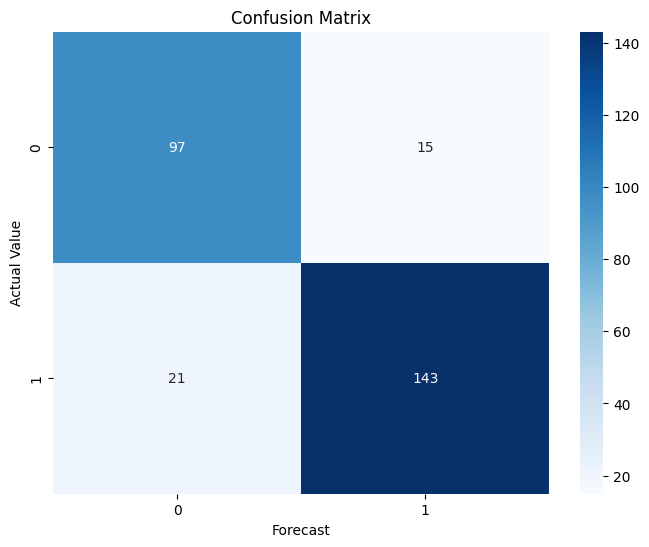

In [7]:
models_list = sorted(models_list, key=lambda d: d['model_accuracy'])
best_model = models_list[-1]
best_model_clf = best_model.get("model_instance")
y_pred = best_model_clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Forecast')
plt.ylabel('Actual Value')
plt.title('Confusion Matrix')
plt.show()

In [8]:
print(best_model)

{'model_name': 'Random Forest', 'model_instance': RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=1000), 'model_accuracy': 0.8695652173913043, 'train_time': datetime.timedelta(seconds=41, microseconds=231760)}


## ROC curve (AUC)
<p>The AUC is a metric that evaluates the ability of a classification model to distinguish correctly between two classes. It is used to compare models, select relevant features, establish classification thresholds, and monitor performance over time. The AUC curve summarizes the overall quality of the model, regardless of the chosen cutoff point, and it is a widely used measure in the analysis of classifier performance.<p>

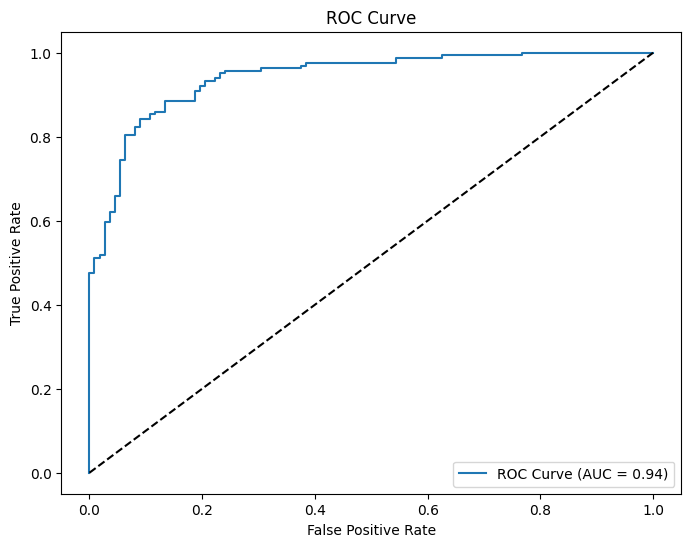

In [9]:
y_prob = best_model_clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

<b>Conclusion:</b>

Cardiovascular Risk: Patients with elevated cholesterol levels, blood pressure, and Oldpeak tend to be at higher risk. These factors are known to affect heart health.

Demographic Factors: Age and sex show a clear association, with older men being more affected, consistent with clinical studies.

Specific Clinical Profiles: Changes in ECG, types of chest pain, and exercise-induced angina are significant variables. Asymptomatic individuals and those with flat ST inclination require more medical attention.

The classification model used was Random Forest, implemented with the RandomForestClassifier, configured with the splitting criterion set to entropy and a maximum depth of 7. The model achieved an accuracy of 87.68%, demonstrating robust performance in the classification task. The total training time was approximately 34.78 seconds, reflecting efficient processing.

The model evaluation was conducted through a confusion matrix, which showed that the model correctly classified 94 instances of class 0 and 144 instances of class 1, while recording 14 false positives and 20 false negatives. Additionally, the area under the curve (AUC) was calculated, resulting in 0.94, indicating an excellent ability to discriminate between classes, highlighting the model's effectiveness in predicting correct outcomes.